In [1]:
%cd ../

/home/dmoreno/pipeline_v4_final/pipeline/training/lc_classifiers/models/experimentation


In [2]:
%ls

ATAT/  classifiers/  images/  MS-ATAT/  notebooks/


In [3]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import os
#os.environ["PATH"] = "/home/users/dmoreno2016/.TinyTeX/bin/x86_64-linux:" + os.environ["PATH"]

#plt.rcParams.update({
#    "text.usetex": True,
#    "pgf.texsystem": "pdflatex",
#    "font.family": "serif",
#    "font.serif": ["Palatino"],
#})

import warnings
warnings.filterwarnings('ignore')

In [4]:
mapping = {
    "SNIa": "SNIa",
    "SNIbc": "SNIbc",
    "SNIIb": "Others", # Se ignora
    "SNII": "SNII",
    "SNIIn": "SNII",
    "SLSN": "SLSN",
    "TDE": "Others",  # Se ignora
    "Microlensing": "Others",  # Se ignora
    "QSO": "QSO",
    "AGN": "AGN",
    "Blazar": "Blazar",
    "YSO": "YSO",
    "CV/Nova": "CV/Nova",
    "LPV": "LPV",
    "EA": "E",
    "EB/EW": "E",
    "Periodic-Other": "Periodic-Other",
    "RSCVn": "Periodic-Other",
    "CEP": "CEP",
    "RRLab": "RRL",
    "RRLc": "RRL",
    "DSCT": "DSCT"
}

order_classes_sanchez_tax = [
    "SNIa", "SNIbc", "SNII", "SLSN",
    "QSO", "AGN", "Blazar",
    "YSO", "CV/Nova", "LPV", "E",
    "DSCT", "RRL", "CEP", "Periodic-Other", "Others"
    ]

class_hierarchy_sanchez_tax = {
    "Transient": ["SNIa", "SNIbc", "SNII", "SLSN"],
    "Periodic": [
        "LPV",
        "E",
        "Periodic-Other",
        "CEP",
        "RRL",
        "DSCT",
    ],
    "Stochastic": [
        "QSO",
        "AGN",
        "Blazar",
        "YSO",
        "CV/Nova",
    ],
}

# Lista de días evaluados
list_time_eval = ['8', '16', '32', '64', '128', '256', '512', '1024', 'None']

path_save_imgs = 'images'

os.makedirs(f'{path_save_imgs}', exist_ok=True)

In [5]:
mlflow.set_tracking_uri("file:./ATAT/results/ml-runs")

data_name =  'ztf_ff_20folds'
experiment_name = f"classification/{data_name}/testing"

experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment:
    experiment_id = experiment.experiment_id
    print(f"Experiment ID for '{experiment_name}': {experiment_id}")
else:
    print(f"Experiment '{experiment_name}' not found.")

runs = mlflow.search_runs(experiment_ids=[experiment_id])
runs = runs[
    (runs.status == 'FINISHED') & 
    (runs['metrics.mix/f1s_test/None_days'].notna())
    ]

# Identificadores de cada fold
fold_run = {v: k for k, v in zip(runs['run_id'], runs['params.general/fold'])}

display(runs.head())
print(runs.shape)
print(fold_run)

Experiment ID for 'classification/ztf_ff_20folds/testing': 245279619942506979


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.loss_test/128_days/mix,metrics.loss_test/1024_days/total,metrics.mix/acc_test/16_days,metrics.loss_test/256_days/mix,...,params.general/force_online_opt,params.lc/max_pool_kernel,params.general/num_classes,params.lc/num_heads,tags.mlflow.source.name,tags.mlflow.source.git.commit,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.parentRunId
0,7e904626d55d4717917cc4e9f41bd9e2,245279619942506979,FINISHED,file:///home/dmoreno/pipeline_v4_final/pipelin...,2025-03-05 09:54:48.048000+00:00,2025-03-05 16:18:15.912000+00:00,0.451963,2.088435,0.784071,0.449942,...,False,5,22,4,training.py,5c6102a61b03fabc8148db14effaf2b91e61874b,Fold_8_2025-03-05_09-54-47,LOCAL,dmoreno,6bc9aaaadff7401c9ca63c05eb632f23
2,57eca164e1bd43dfbbb3c1ec8fbb67a1,245279619942506979,FINISHED,file:///home/dmoreno/pipeline_v4_final/pipelin...,2025-03-05 09:53:25.427000+00:00,2025-03-05 15:00:59.143000+00:00,0.448890,2.072606,0.773967,0.428785,...,False,5,22,4,training.py,5c6102a61b03fabc8148db14effaf2b91e61874b,Fold_7_2025-03-05_09-53-24,LOCAL,dmoreno,20ebdcbf9ef045a9a4ab6c81b111a9fd
4,7dfbf6865cf04d9e84a1f70c2d09e728,245279619942506979,FINISHED,file:///home/dmoreno/pipeline_v4_final/pipelin...,2025-03-04 05:22:37.801000+00:00,2025-03-04 10:23:02.896000+00:00,0.434758,2.079930,0.774175,0.422983,...,False,5,22,4,training.py,5c6102a61b03fabc8148db14effaf2b91e61874b,Fold_4_2025-03-03_09-45-22,LOCAL,dmoreno,87e3a59bb7bb4250975a33b839d16963
5,d37c7c5dd8354332b03b1851f0149f2a,245279619942506979,FINISHED,file:///home/dmoreno/pipeline_v4_final/pipelin...,2025-03-03 22:46:28.714000+00:00,2025-03-04 05:22:37.796000+00:00,0.451710,2.051739,0.783391,0.429277,...,False,5,22,4,training.py,5c6102a61b03fabc8148db14effaf2b91e61874b,Fold_2_2025-03-03_09-45-22,LOCAL,dmoreno,87e3a59bb7bb4250975a33b839d16963
6,efc132ed9ff04f30bc820607942e8939,245279619942506979,FINISHED,file:///home/dmoreno/pipeline_v4_final/pipelin...,2025-03-03 09:45:23.380000+00:00,2025-03-03 22:46:28.709000+00:00,0.480267,2.055504,0.790984,0.457499,...,False,5,22,4,training.py,5c6102a61b03fabc8148db14effaf2b91e61874b,Fold_1_2025-03-03_09-45-22,LOCAL,dmoreno,87e3a59bb7bb4250975a33b839d16963


(20, 138)
{'8': '7e904626d55d4717917cc4e9f41bd9e2', '7': '57eca164e1bd43dfbbb3c1ec8fbb67a1', '4': '7dfbf6865cf04d9e84a1f70c2d09e728', '2': 'd37c7c5dd8354332b03b1851f0149f2a', '1': 'efc132ed9ff04f30bc820607942e8939', '5': '62e883e5b89f4df3a5f68510c8e68ad8', '14': '0e92a365d4724e35b5101f26c9246009', '17': '822c23da966b42fd8eb6ba0b9cb898d6', '11': 'ac5968ac75d04cff9b8dc0d8ceefbca0', '13': '39eaa640969f4608bdc43030d95a00be', '16': '8871ab072ae94ea39a28ab4b8c0ca6d0', '10': 'bc9d68d233aa44d0b80b6857354b8678', '19': 'afc360afa539404b86ef611a42a14d73', '18': 'db764a89657c44bb9bb1f81203b902e0', '15': 'e7d8741752b647fbb7cd45a8382bc1d2', '12': 'c2f1cf053b934280a69889400c3e7c01', '9': '11d1214f9b504dffb9049bb8eb7cc18a', '6': 'e7b58cf8cb504c918cd81fd468733632', '3': 'f8fc9f30587349558851b7d780750260', '0': '4e54be66c0484ab690767b4cbef2aa64'}


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Inicializar estructuras para almacenar resultados
atat_y_pred_fold = {}
hbrf_y_pred_fold = {}
combined_y_pred_fold = {}
y_test_fold = {}

# Iterar sobre los valores de time_eval (días)
for time_eval in list_time_eval:
    atat_y_pred_fold[f'{time_eval}_days'] = []
    hbrf_y_pred_fold[f'{time_eval}_days'] = []
    combined_y_pred_fold[f'{time_eval}_days'] = []
    y_test_fold[f'{time_eval}_days'] = []  # Guardar valores reales (y_true)

    for fold, run_id in fold_run.items():
        # Cargar predicciones de ATAT
        path_clf_report = f'./ATAT/results/ml-runs/{experiment_id}/{run_id}/artifacts'
        atat_df_predictions = pd.read_parquet(f'{path_clf_report}/ndays_results/LCs/predictions_test_{time_eval}.parquet').set_index('id')
        y_test = atat_df_predictions['y_true'].values
        atat_y_pred = atat_df_predictions['y_pred'].values

        y_test = [mapping[label] for label in y_test]
        atat_y_pred = [mapping[label] for label in atat_y_pred]

        # Cargar predicciones de HBRF
        root = 'classifiers/results/241209_ndetge8_20folds/HBRF_20250306-141821'
        hbrf_df_predictions = pd.read_parquet(f'{root}/fold_{fold}/predictions_test.parquet')
        hbrf_df_predictions = hbrf_df_predictions[hbrf_df_predictions['shorten'] == time_eval]
        hbrf_df_predictions.index = hbrf_df_predictions.index.astype(str).str.split('_').str[1]
        hbrf_df_predictions = hbrf_df_predictions.reindex(atat_df_predictions.index)
        hbrf_y_pred = hbrf_df_predictions['y_pred'].values

        hbrf_y_pred = [mapping[label] for label in hbrf_y_pred]

        # Promediar predicciones de ATAT y HBRF
        #combined_y_pred_prob_fold = (atat_df_predictions[order_classes] + hbrf_df_predictions[order_classes]) / 2
        
        # Guardar valores en estructuras
        atat_y_pred_fold[f'{time_eval}_days'].append(atat_y_pred)
        hbrf_y_pred_fold[f'{time_eval}_days'].append(hbrf_y_pred)
        #combined_y_pred_fold[f'{time_eval}_days'].append(combined_y_pred_prob_fold.idxmax(axis=1))
        y_test_fold[f'{time_eval}_days'].append(y_test)


In [7]:
from sklearn.metrics import classification_report, confusion_matrix

metrics_by_time = {time_eval: {"ATAT": [], "HBRF": []} for time_eval in list_time_eval}
confusion_matrices = {} 

for time_eval in list_time_eval:
    for fold in range(len(fold_run)):  # Iterar sobre los folds
        y_test = y_test_fold[f"{time_eval}_days"][fold]
        y_pred_atat = atat_y_pred_fold[f"{time_eval}_days"][fold]
        y_pred_hbrf = hbrf_y_pred_fold[f"{time_eval}_days"][fold]

        # Calcular reporte de métricas inter
        report_atat_inter = classification_report(y_test, y_pred_atat, output_dict=True)
        report_hbrf_inter = classification_report(y_test, y_pred_hbrf, output_dict=True)

        # Guardar métricas
        metrics_by_time[time_eval]["ATAT"].append(report_atat_inter)
        metrics_by_time[time_eval]["HBRF"].append(report_hbrf_inter)

        # Guardar matrices de confusión solo cuando time_eval es None
        if time_eval == 'None':
            if time_eval not in confusion_matrices:
                confusion_matrices[time_eval] = {"ATAT": [], "HBRF": []}
            
            cm_atat = confusion_matrix(y_test, y_pred_atat, labels=order_classes_sanchez_tax)
            cm_hbrf = confusion_matrix(y_test, y_pred_hbrf, labels=order_classes_sanchez_tax)

            confusion_matrices[time_eval]["ATAT"].append(cm_atat)
            confusion_matrices[time_eval]["HBRF"].append(cm_hbrf)

In [8]:
import pandas as pd
import numpy as np

# Diccionario dinámico para almacenar los datos de cada categoría
data_inter = {category: [] for category in order_classes_sanchez_tax}
data_inter_macro = []

for time_eval in list_time_eval:
    for category in order_classes_sanchez_tax:
        row = [time_eval]
        for model in ["ATAT", "HBRF"]:
            recalls = [metrics_by_time[time_eval][model][fold][category]["recall"] * 100 
                       for fold in range(len(fold_run))]
            precision = [metrics_by_time[time_eval][model][fold][category]["precision"] * 100 
                         for fold in range(len(fold_run))]
            f1_score = [metrics_by_time[time_eval][model][fold][category]["f1-score"] * 100 
                        for fold in range(len(fold_run))]

            row.extend([
                f"{np.mean(precision):.2f} ± {np.std(precision):.2f}",
                f"{np.mean(recalls):.2f} ± {np.std(recalls):.2f}",
                f"{np.mean(f1_score):.2f} ± {np.std(f1_score):.2f}"
            ])

        # Guardar la fila en el diccionario correspondiente a la categoría
        data_inter[category].append(row)

    # Calcular y guardar macro promedio por cada time_eval
    row_macro = [time_eval]
    for model in ["ATAT", "HBRF"]:
        macro_precision = [metrics_by_time[time_eval][model][fold]["macro avg"]["precision"] * 100 
                           for fold in range(len(fold_run))]
        macro_recall = [metrics_by_time[time_eval][model][fold]["macro avg"]["recall"] * 100 
                        for fold in range(len(fold_run))]
        macro_f1 = [metrics_by_time[time_eval][model][fold]["macro avg"]["f1-score"] * 100 
                    for fold in range(len(fold_run))]

        row_macro.extend([
            f"{np.mean(macro_precision)} ± {np.std(macro_precision)}",
            f"{np.mean(macro_recall)} ± {np.std(macro_recall)}",
            f"{np.mean(macro_f1)} ± {np.std(macro_f1)}"
        ])
    
    data_inter_macro.append(row_macro)

# Crear DataFrames para cada categoría dinámicamente
columns = ["Time (days)", 
           "ATAT Precision", "ATAT Recall", "ATAT F1-score",
           "HBRF Precision", "HBRF Recall", "HBRF F1-score"]

df_inter = {category: pd.DataFrame(data, columns=columns).set_index("Time (days)") 
            for category, data in data_inter.items()}

# Crear DataFrame para Macro Promedio
df_inter_macro = pd.DataFrame(data_inter_macro, columns=columns).set_index("Time (days)")

# -------------------------------
# **MOSTRAR RESULTADOS**
# -------------------------------
display(df_inter_macro.head())
print(f'Number of classes: {len(df_inter)}')

,ATAT Precision,ATAT Recall,ATAT F1-score,HBRF Precision,HBRF Recall,HBRF F1-score
Time (days),,,,,,
8,65.9039187479703 ± 1.0791817191611484,65.8477960630244 ± 0.7046866898404414,65.21678966614238 ± 0.8479539167571035,60.9848293903194 ± 0.2685277007590446,65.58945511632423 ± 0.44387024432683286,61.62445914682314 ± 0.3121769415279912
16,70.66959105383033 ± 1.3060722055537601,69.49962212861888 ± 0.5389379521376743,69.49822759919076 ± 0.771881567316355,65.42648702274461 ± 0.2530522115244823,69.81342180484174 ± 0.3894368430128315,66.61638888469511 ± 0.28324027833325655
32,74.84165773636425 ± 1.0995666067513072,73.30049386119002 ± 0.5006094230822221,73.58584284488543 ± 0.6289172049584141,71.49290123730269 ± 0.28302334549861397,75.08085919667052 ± 0.343712866420588,72.74836125161525 ± 0.3037299040711324
64,77.75304256854173 ± 0.9850489483003018,76.00520909412734 ± 0.6162885117620479,76.49489549770007 ± 0.678106569930903,74.95531693017827 ± 0.2836132405040056,77.60288291036804 ± 0.2832381975959249,75.99820196335139 ± 0.27763377039612014
128,79.12968429365677 ± 0.9369423239147847,77.35447113593678 ± 0.5849078727433419,77.87473804188889 ± 0.6041592997609433,76.02976327371772 ± 0.29545727682834416,78.40547957608463 ± 0.28455032231753247,76.98790080914492 ± 0.29210616307630344


Number of classes: 16


In [9]:
def get_mean_std(list_values):
    means = []
    std_devs = []
    for values in list_values:
        mean, std_dev = values.split(" ± ")
        means.append(float(mean))
        std_devs.append(float(std_dev))
    return means, std_devs

In [10]:
atat_f1, atat_f1_err =  get_mean_std(df_inter_macro['ATAT F1-score'].values)
hbrf_f1, hbrf_f1_err =  get_mean_std(df_inter_macro['HBRF F1-score'].values)
days = [int(k) if k != 'None' else 2039 for k in df_inter_macro.index.values]

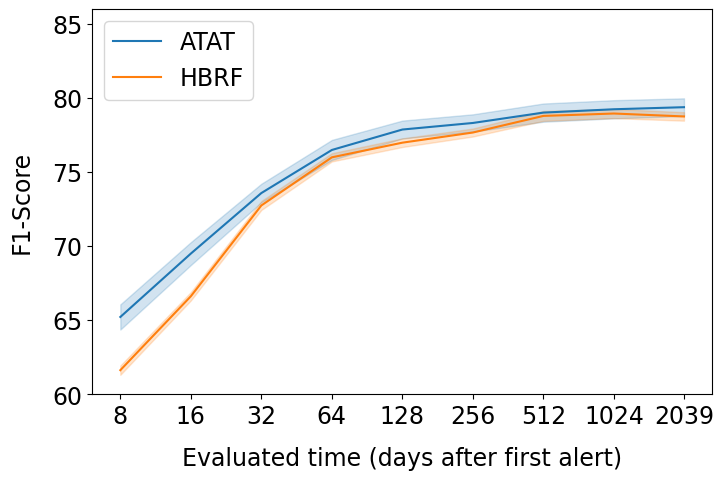

In [19]:
# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 5))

# Graficar los datos con barras de error
ax.plot(days, atat_f1, linestyle='-', label='ATAT', color='tab:blue')
ax.plot(days, hbrf_f1, linestyle='-', label='HBRF', color='tab:orange')

ax.fill_between(days, np.array(atat_f1) - np.array(atat_f1_err), np.array(atat_f1) + np.array(atat_f1_err), color='tab:blue', alpha=0.2)
ax.fill_between(days, np.array(hbrf_f1) - np.array(hbrf_f1_err), np.array(hbrf_f1) + np.array(hbrf_f1_err), color='tab:orange', alpha=0.2)

# Resaltar el máximo F1-score de todos los modelos
max_f1 = max(max(atat_f1), max(hbrf_f1)) 
max_idx = None
max_day = None

# Determinar a qué modelo y día pertenece el máximo F1-score
for idx, (a, h) in enumerate(zip(atat_f1, hbrf_f1)):
    if max_f1 in [a, h]:  # Verificar a qué curva pertenece
        max_idx = idx
        max_day = days[idx]
        break

# Dibujar línea y anotación del máximo F1-score
#ax.axhline(y=max_f1, linestyle='dashed', color='gray', alpha=0.6)
#ax.text(max_day, max_f1 + 0.01, f"Max F1: {max_f1:.3f}", ha="center", fontsize=10, color="gray", fontweight="bold")

# Configurar el eje X con escala logarítmica en base 2
list_time_to_eval = sorted(days)  # Asegurar que los valores estén ordenados
ax.set_xscale('log', base=2)
ax.set_xticks(list_time_to_eval)

# Configurar etiquetas, título y límites
fs = 17
#ax.set_title('F1-Score by Evaluation Time', fontsize=fs + 2, fontweight='bold', pad=15)
ax.set_xlabel('Evaluated time (days after first alert)', fontsize=fs, labelpad=13)
ax.set_ylabel('F1-Score', fontsize=fs, labelpad=13)
ax.tick_params(axis='y', labelsize=fs)
ax.set_xticklabels(list_time_to_eval, fontsize=fs)
ax.set_ylim(60, 86)
ax.legend(fontsize=fs, loc='upper left')

# Mostrar la gráfica
plt.savefig(f"{path_save_imgs}/eval_time_bottom_lvl_new_to_sanchez_tax.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_confusion_matrix(matrices, order_classes, class_hierarchy=None, path_save=None, figsize=(13, 13), shrink=0.675):
    # Calculando la media y la desviación estándar
    median_matrix = np.median(matrices, axis=0)
    p5_matrix = np.abs(median_matrix - np.percentile(matrices, 5, axis=0))
    p95_matrix = np.abs(median_matrix - np.percentile(matrices, 95, axis=0)) 

    matrices_norm = np.array([m / m.sum(axis=1, keepdims=True) for m in matrices])
    matrices_norm = np.nan_to_num(matrices_norm)
    mean_matrices_norm = np.mean(matrices_norm, axis=0)
        
    # Graficando la matriz media
    cmap = plt.cm.Blues
    fig, ax = plt.subplots(figsize=figsize) #, dpi=110)
    #norm = mcolors.Normalize(vmin=0, vmax=np.max(median_matrix))
    #median_matrix = 
    im = ax.imshow(np.around(mean_matrices_norm, decimals=2), interpolation='nearest', cmap=cmap, aspect=.9, vmax=1)#, #norm=norm)

    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, ax=ax, pad=0.02, aspect=40, shrink=shrink)
    cbar.ax.tick_params(labelsize=17)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(median_matrix.shape[0]):
        for j in range(median_matrix.shape[1]):
            mean_val = int(median_matrix[i, j])
            p5_val = int(p5_matrix[i, j])
            p95_val = int(p95_matrix[i, j])

            if mean_matrices_norm[i, j] >= 0.0005:
                text = f'{mean_val}'
                text_p95 = f'+{p95_val}' if p95_val != 0 else ''  # P95 arriba
                text_p5 = f'−{p5_val}' if p5_val != 0 else ''  # P5 abajo

                color = "white" if mean_matrices_norm[i, j] > 0.5 else new_color

                ax.text(j - 0.13, i, text, ha="center", va="center", color=color, fontsize=15.5)
                ax.text(j + 0.018, i - 0.15, text_p95, ha="left", va="bottom", color=color, fontsize=11)
                ax.text(j + 0.018, i + 0.15, text_p5, ha="left", va="top", color=color, fontsize=11)
            else:
                text = f'{mean_val}'
                color = "white" if mean_matrices_norm[i, j] > 0.5 else new_color
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=12.5)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    if class_hierarchy is not None:
        for class_list in class_hierarchy.values():
            indices = [order_classes.index(cls) for cls in class_list if cls in order_classes]
            if indices:
                min_idx, max_idx = min(indices), max(indices)
                rect = patches.Rectangle(
                    (min_idx - 0.5, min_idx - 0.5),  # Esquina superior izquierda
                    max_idx - min_idx + 1,  # Ancho
                    max_idx - min_idx + 1,  # Alto
                    linewidth=2, edgecolor="black", facecolor='none', clip_on=False
                )
                ax.add_patch(rect)

    ax.set_ylabel('True Label', fontsize=17)
    ax.set_xlabel('Predicted Label', fontsize=17)

    plt.setp(ax.get_xticklabels(), rotation=65, ha='center', va='top', rotation_mode="default")
    plt.tight_layout()

    if path_save is not None:
        plt.savefig(f"{path_save}", format="pdf", bbox_inches="tight")
    plt.show()

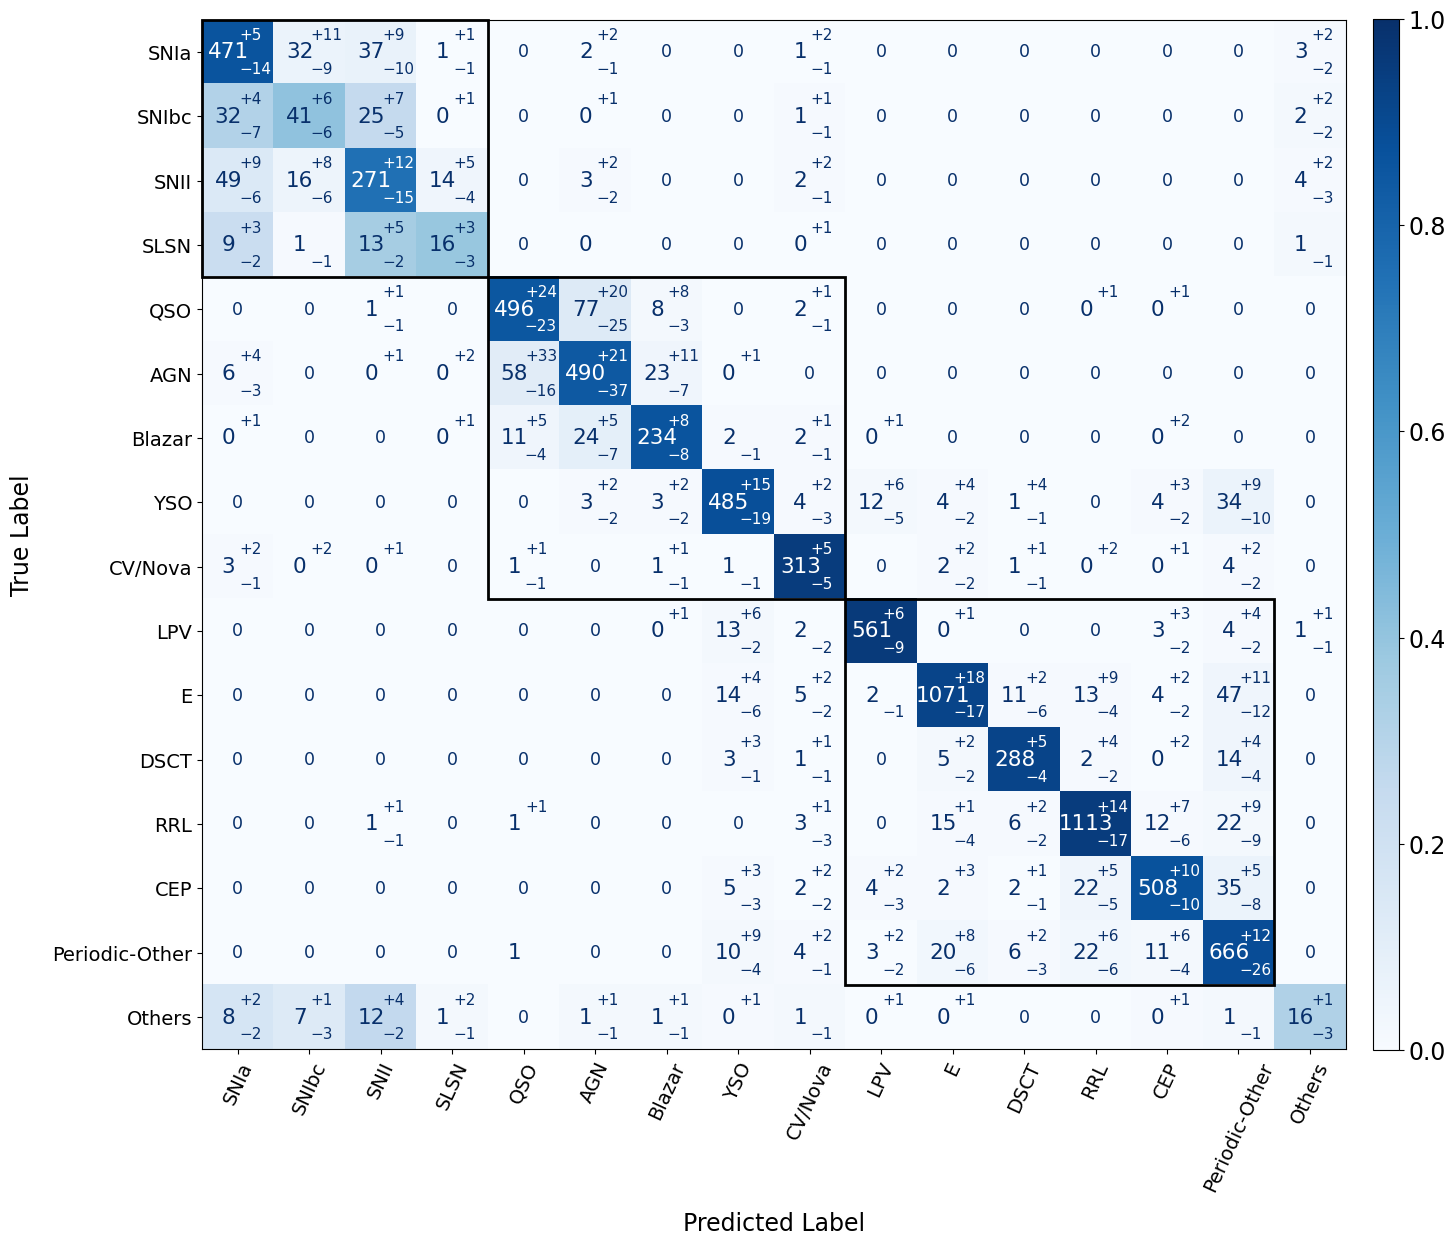

In [16]:
matrices = confusion_matrices['None']['ATAT']
path_save = f'{path_save_imgs}/cm_atat_bottom_lvl_new_to_sanchez_tax.pdf'
get_confusion_matrix(matrices, order_classes_sanchez_tax, class_hierarchy=class_hierarchy_sanchez_tax, path_save=path_save, figsize=(16,13), shrink=0.92)

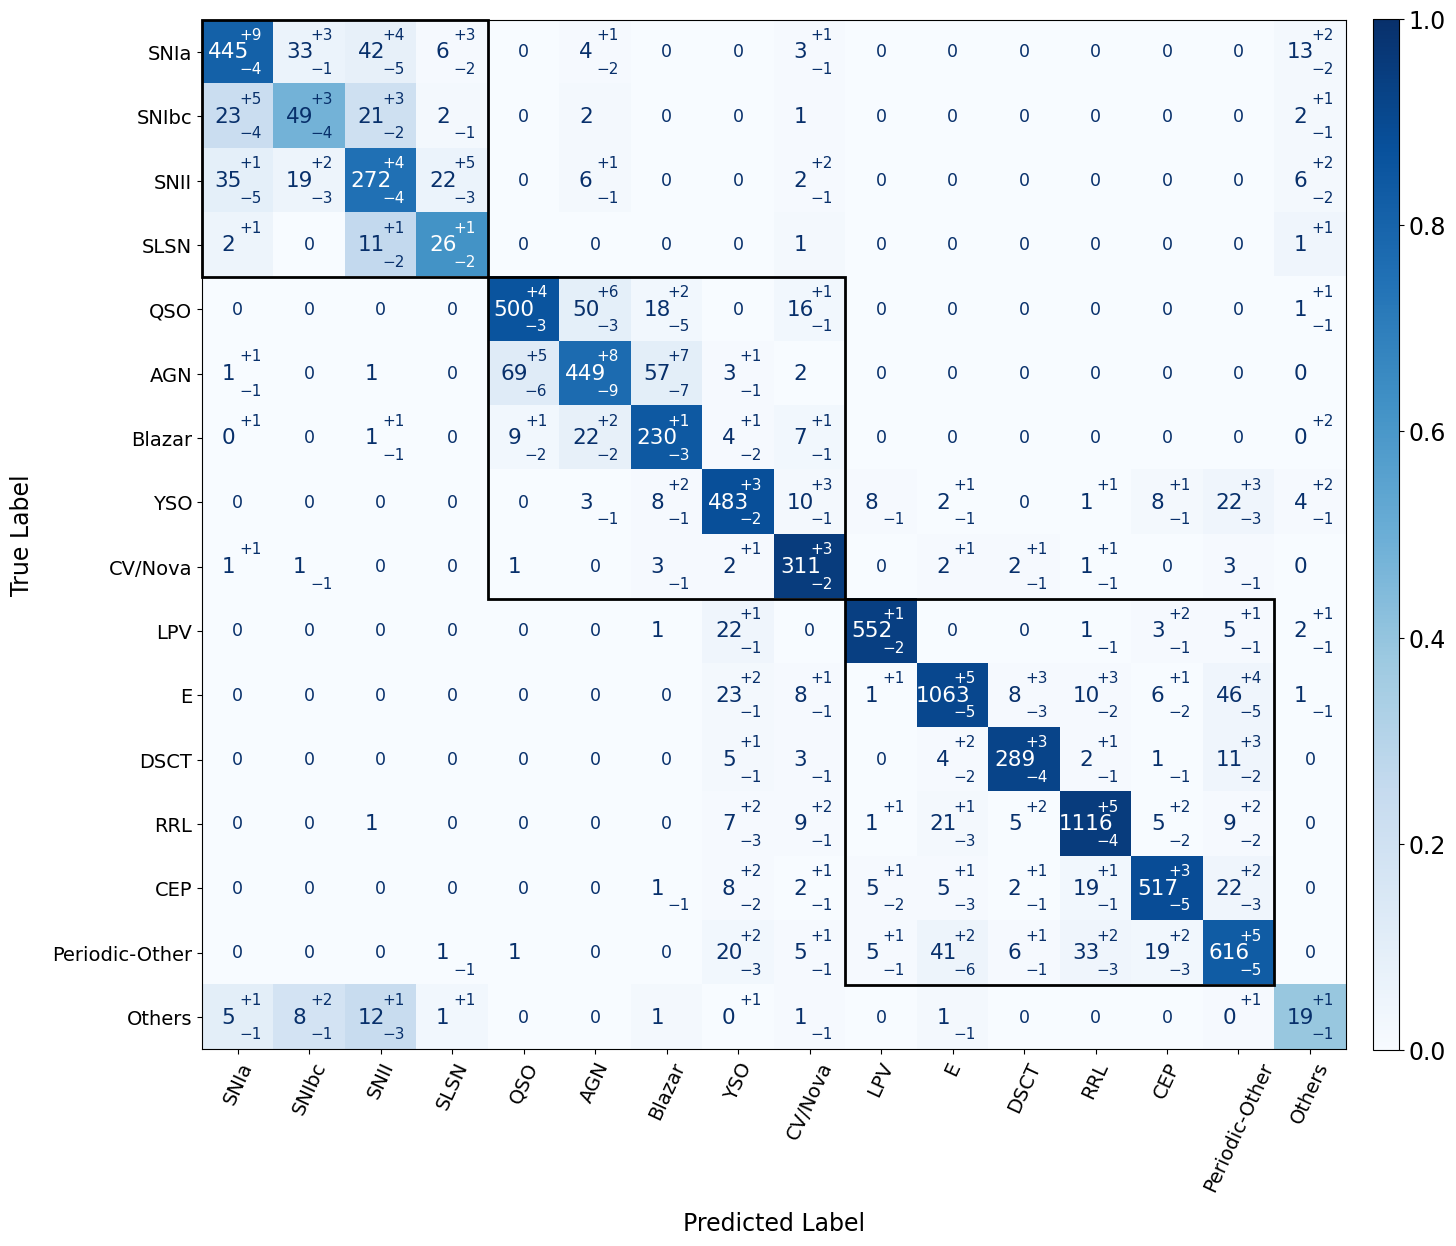

In [17]:
matrices = confusion_matrices['None']['HBRF']
path_save = f'{path_save_imgs}/cm_hbrf_bottom_lvl_new_to_sanchez_tax.pdf'
get_confusion_matrix(matrices, order_classes_sanchez_tax, class_hierarchy=class_hierarchy_sanchez_tax, path_save=path_save, figsize=(16,13), shrink=0.92)